In [1]:
from __future__ import division
from __future__ import print_function

import os
import random
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from IPython.display import display, Math
from scipy.misc import imread

In [2]:
def plot(errs, title='Error', ylabel='Error %', step=1):
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel(ylabel)
    plt.plot(range(0, len(errs) * step, step), errs)
    plt.show()

def mean_norm(dataset):
    """
    subtract mean and do normalization for each image
    Args:
        dataset: dataset with shape [N, H, W, C]
                 N data points, Height H, Width W, Channel C
    Return:
        dataset: processed dataset
    """
    N, H, W, C = dataset.shape
    X = dataset.reshape((N, -1))
    X -= np.mean(X, axis = 0)
    X /= np.std(X, axis = 0)
    X = X.reshape((N, H, W, C))
    return X

In [3]:
# Read label names
with open('tiny-imagenet-200/wnids.txt') as f:
    wnids = {l.strip(): i for i, l in enumerate(f)}

In [4]:
# Read training images and construct labels
imgs = []
labs = []
for wnid in wnids.keys():
    subdir = 'tiny-imagenet-200/train/%s/images/' % wnid
    files = [subdir + s for s in os.listdir(subdir)]
    imgs.extend([imread(f, mode='RGB') for f in files])
    labs.extend([np.eye(200)[wnids[wnid]]] * len(files))

In [5]:
# Shuffle training images and labels
comb = zip(labs, imgs)
random.shuffle(comb)
s_labs, s_imgs = zip(*comb)

In [6]:
# Put into training dictionary
dat_train = {
    'imgs': mean_norm(np.array(s_imgs, dtype=np.float32)),
    'labs': np.array(s_labs, dtype=np.int32),
}

In [7]:
# Read test labels
fname_map = {}
with open('tiny-imagenet-200/val/val_annotations.txt') as f:
    for line in f:
        dat = line.strip().split()
        fname_map[dat[0]] = dat[1]

In [8]:
# Read test images and construct labels
imgs = []
labs = []
subdir = 'tiny-imagenet-200/val/images/'
for f in os.listdir(subdir):
    path = subdir + f
    imgs.append(imread(path, mode='RGB'))
    labs.append(np.eye(200)[wnids[fname_map[f]]])

In [9]:
# Put into testing dictionary
dat_test = {
    'imgs': mean_norm(np.array(imgs, dtype=np.float32)),
    'labs': np.array(labs, dtype=np.int32),
}

In [10]:
learning_rate = 0.0001

# Network shape

def weight(shape):
    return tf.Variable(tf.truncated_normal(shape, stddev=0.1))
def bias(shape):
    return tf.Variable(tf.constant(0.1, shape=shape))

activate = tf.nn.relu
def conv(x, filter_size, filters_out, stride=1):
    filters_in = x.get_shape()[-1].value
    w = weight([filter_size, filter_size, filters_in, filters_out])
    b = bias([filters_out])
    return activate(
        tf.nn.conv2d(x, w, [1, stride, stride, 1], 'SAME') + b)
def fc(x, nodes):
    vec_in = x.get_shape()[-1].value
    w = weight([vec_in, nodes])
    b = bias([nodes])
    return tf.matmul(x, w) + b

# Creates entire network. Takes a function which makes
# the convolutional layers.
def mk_net(mk_conv):
    # Endpoints
    _x = tf.placeholder(tf.float32, [None, 64, 64, 3])
    _y = tf.placeholder(tf.float32, [None, 200])

    _conv = mk_conv(_x)

    # Flatten, then fully-connected 500 node
    _, w, h, c = [d.value for d in _conv.get_shape()]
    _flat = tf.reshape(_conv, [-1, w * h * c])
    _hidd = activate(fc(_flat, 500))
    _out = fc(_hidd, 200)

    # Optimization
    _cel = tf.nn.softmax_cross_entropy_with_logits(logits=_out, labels=_y)
    _loss = tf.reduce_mean(_cel)
    _opt = tf.train.AdamOptimizer(learning_rate).minimize(_loss)

    # Validation
    _pred = tf.argmax(_out, 1)
    _ans = tf.argmax(_y, 1)
    _err = tf.reduce_mean(tf.cast(tf.not_equal(_pred, _ans), tf.float32))

    _init = tf.global_variables_initializer()
    
    # Return the nodes we need
    return {
        'x': _x,
        'y': _y,
        'opt': _opt,
        'pred': _pred,
        'err': _err,
        'init': _init,
    }

def plain(x):  
    # Create convolutional layers
    # 16 layers, 3x3 convolutions
    # Pooling via stride + channel increase every 8 layers
    _cur = x
    filters_out = 8
    for _ in range(2):
        _cur = conv(_cur, 3, filters_out, 2)
        for _ in range(7):
            _cur = conv(_cur, 3, filters_out, 1)
        filters_out *= 2
    return _cur

def resnet(decay_factor=1):
    def wrapped(x):
        # Same as plain, but add residual every 2 layers
        # Optional decaying factor
        _cur = x
        filters_out = 8

        for _ in range(2):
            _cur = conv(_cur, 3, filters_out, 2)
            _res = _cur = conv(_cur, 3, filters_out, 1)
            for _ in range(3):
                _cur = conv(_cur, 3, filters_out, 1)
                _res = _cur = conv(_cur, 3, filters_out, 1) + _res * decay_factor
            filters_out *= 2
        return _cur
    return wrapped

def ext_resnet(x):
    # Our original design.
    # Add residual every multiple of 2 layers
    _cur = x
    filters_out = 8
    
    def add_residuals(cur, preds):
        for i, pred in enumerate(reversed(preds)):
            cur += pred / i
        return cur
            
    for _ in range(2):
        _cur = conv(_cur, 3, filters_out, 2)
        _cur = conv(_cur, 3, filters_out, 1)
        preds = [_cur]
        for _ in range(3):
            _cur = conv(_cur, 3, filters_out, 1)
            _cur = conv(_cur, 3, filters_out, 1)
            _cur = add_residuals(_cur, preds)
            preds.append(_cur)
        filters_out *= 2
    return _cur

In [11]:
# Training
def train(net, train, test, epochs, batch_size, err_step=1):
    e_test = []
    
    with tf.Session() as sess:
        sess.run(net['init'])
        for epoch in range(epochs):
            print(epoch, end='.')

            # Process all batches
            for idx in range(0, len(imgs), batch_size):
                print('.', end='')
                sess.run(net['opt'], {
                    net['x']: train['imgs'][idx:idx + batch_size],
                    net['y']: train['labs'][idx:idx + batch_size],
                })
                
            # Record stats
            if not epoch % err_step:
                e_test.append(sess.run(net['err'], {
                    net['x']: test['imgs'],
                    net['y']: test['labs'],
                }))
            
    print('\nDONE')
    return e_test

In [12]:
# Hyperparameters
n_epoch = 100
n_batch = 100

In [13]:
# Make networks
plain_net = mk_net(plain)
resnet_net = mk_net(resnet())
ext_resnet_net = mk_net(ext_resnet)
decay_resnet_net = mk_net(resnet(0.5))

In [ ]:
# Train networks
def do_train(net):
    return train(plain_net, dat_train, dat_test, n_epoch, n_batch, 10)

In [ ]:
print("TRAINING: PLAIN")
e_plain = do_train(plain_net)

TRAINING: PLAIN
0.....................................................................................................1.....................................................................................................2.....................................................................................................3.....................................................................................................4.....................................................................................................5.....................................................................................................6......................................................................................................

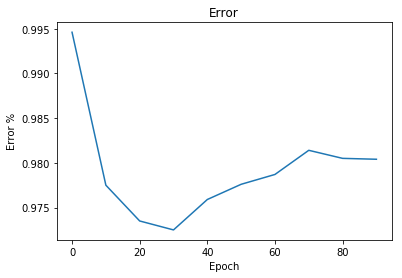

In [ ]:
plot(e_plain, step=10)

In [ ]:
print("TRAINING: RESNET")
e_resnet = do_train(resnet_net)

TRAINING: RESNET
0.....................................................................................................1.....................................................................................................2.....................................................................................................3.....................................................................................................4.....................................................................................................5.....................................................................................................6.....................................................................................................7.....................................................................................................8.....................................................................................................9................................................................

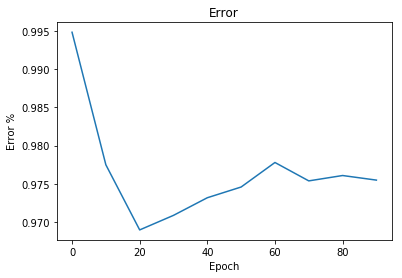

In [ ]:
plot(e_resnet, step=10)

In [ ]:
print("TRAINING: EXTENDED RESNET")
e_ext_resnet_net = do_train(ext_resnet_net)

TRAINING: EXTENDED RESNET
0.....................................................................................................1.....................................................................................................2.....................................................................................................3.....................................................................................................4.....................................................................................................5.....................................................................................................6.....................................................................................................7.....................................................................................................8.....................................................................................................9.......................................................

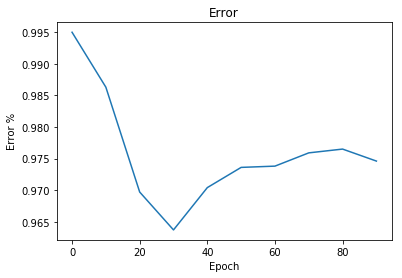

In [25]:
plot(e_ext_resnet_net, step=10)

In [ ]:
print("TRAINING: DECAYING RESNET")
e_decay_resnet_net = do_train(decay_resnet_net)

.........................................................4.............................................

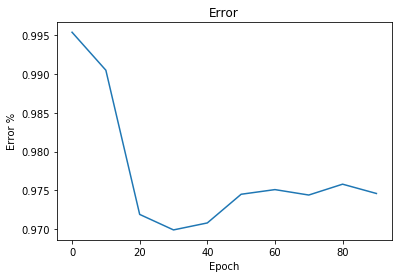

In [26]:
plot(e_decay_resnet_net, step=10)